In [1]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from tqdm import tqdm

from PIL import Image, ImageOps
import csv

In [2]:
# DATA_DIR = "/Volumes/SSD970/"
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "train_images")

TRAIN_CORONAL_IMAGES_DIR = os.path.join(DATA_DIR, "train_coronal_images")
TRAIN_CORONAL_LABEL_DIR = os.path.join(DATA_DIR, "train_coronal_labels")
TRAIN_SAGITTAL_IMAGES_DIR = os.path.join(DATA_DIR, "train_sagittal_images")
TRAIN_SAGITTAL_LABEL_DIR = os.path.join(DATA_DIR, "train_sagittal_labels")

In [3]:
def read_sagittal_labels(UID):
    img_list = []
    for i in range(512):
        img = np.asarray(Image.open(os.path.join(TRAIN_SAGITTAL_LABEL_DIR, UID, f"{i}.png")))

        img_list.append(img)

    img_list = np.stack(img_list)
    return img_list

UID = "1.2.826.0.1.3680043.11988"
img_list = read_sagittal_labels(UID)
img_list.shape

(512, 256, 256)

보면 잘못 segment 된 부분도 꽤 있다. 8번 척추가 나온것을 볼 수 있다.

[670898, 670898]


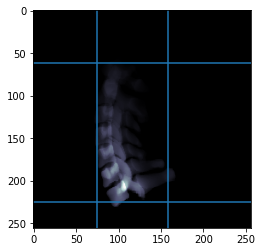

In [4]:
mean_sagittal = np.mean(img_list, axis=0)
x, y, z = img_list.nonzero()
y.sort()
z.sort()
print([len(y), len(z)])
plt.imshow(mean_sagittal, cmap='bone')
plt.axhline(y[int(len(y) * 0.005)])
plt.axhline(y[-int(len(y) * 0.005)])
plt.axvline(z[int(len(z) * 0.005)])
plt.axvline(z[-int(len(z) * 0.005)])
plt.show()

17 개가 빗나갔다. 

In [5]:
len(y[y<60])

1341

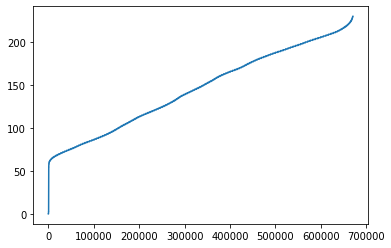

In [6]:
plt.plot(y)

pixel spacing = 0.5136  => 0.2 로 맞추려고 하면 2-

In [7]:
def read_coronal_labels(UID):
    img_list = []
    for i in range(512):
        img = np.asarray(Image.open(os.path.join(TRAIN_CORONAL_LABEL_DIR, UID, f"{i}.png")))

        img_list.append(img)

    img_list = np.stack(img_list)
    return img_list

UID = "1.2.826.0.1.3680043.10921"
coronal_img_list = read_coronal_labels(UID)
coronal_img_list.shape

(512, 256, 256)

[374529, 374529]


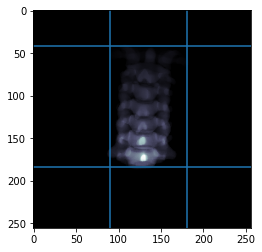

In [8]:
mean_coronal = np.mean(coronal_img_list, axis=0)

x, y, z = coronal_img_list.nonzero()
# plt.imshow(mean_coronal, cmap='bone')
# plt.axhline(y.min())
# plt.axhline(y.max())
# plt.axvline(z.min())
# plt.axvline(z.max())

y.sort()
z.sort()
print([len(y), len(z)])
plt.imshow(mean_coronal, cmap='bone')
plt.axhline(y[int(len(y) * 0.001)])
plt.axhline(y[-int(len(y) * 0.001)])
plt.axvline(z[int(len(z) * 0.001)])
plt.axvline(z[-int(len(z) * 0.001)])

plt.show()

## write csv

In [9]:
def calculate_coronal_boundary(UID):
    img_list = read_coronal_labels(UID)
    x, y, z = img_list.nonzero()
    y.sort()
    z.sort()
    left, top, right, bottom = z[int(len(z) * 0.001)], y[int(len(y) * 0.005)], z[-int(len(z) * 0.005)], y[-int(len(y) * 0.005)]
    return left, top, right, bottom

def calculate_sagittal_boundary(UID):
    img_list = read_sagittal_labels(UID)
    x, y, z = img_list.nonzero()
    y.sort()
    z.sort()
    left, top, right, bottom = z[int(len(z) * 0.001)], y[int(len(y) * 0.005)], z[-int(len(z) * 0.005)], y[-int(len(y) * 0.005)]
    return left, top, right, bottom

In [10]:
header = [
    "UID",
    "coronal_left","coronal_top","coronal_right","coronal_bottom",
    "sagittal_left","sagittal_top","sagittal_right","sagittal_bottom",
]
f = open('meta_boundary_throw_anomaly.csv', 'w', newline='')
writer = csv.writer(f)
writer.writerow(header)

117

In [11]:
def calculate_boundary(UID):
    coronal_left, coronal_top, coronal_right, coronal_bottom = calculate_coronal_boundary(UID)
    sagittal_left, sagittal_top, sagittal_right, sagittal_bottom = calculate_sagittal_boundary(UID)

    writer.writerow([
        UID,
        coronal_left, coronal_top, coronal_right, coronal_bottom,
        sagittal_left, sagittal_top, sagittal_right, sagittal_bottom
    ])


In [12]:
vertical_label_dirs = glob.glob(TRAIN_SAGITTAL_LABEL_DIR + "/**")
for label_dir in tqdm(vertical_label_dirs):
    UID = label_dir.split("/")[-1]
    calculate_boundary(UID)

100%|██████████| 2012/2012 [26:39<00:00,  1.26it/s]


In [13]:
f.close()